In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from tqdm import tqdm_notebook as tqdm

from functions import reduce_mem_usage
from visualize import show_transaction_nans

# Load Data

In [3]:
df_train_trans = pd.read_pickle('data/df_train_trans.pkl')
df_test_trans = pd.read_pickle('data/df_test_trans.pkl')

## Make Prediction for all

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from catboost import CatBoostRegressor as cat
from lightgbm import LGBMRegressor as lgbm
from xgboost import XGBRegressor as xgb
from vecstack import stacking

import tensorflow as tf

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras_tqdm import TQDMNotebookCallback
from livelossplot.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint


def get_train_valid(df_train) : 
    x = df_train.drop(['isFraud'], axis=1)
    y = df_train['isFraud']

    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, shuffle=False)

    print('x_train.shape : %s, y_train.shape : %s' % (x_train.shape, y_train.shape))
    print('x_valid.shape : %s, y_valid.shape : %s' % (x_valid.shape, y_valid.shape))

    return x_train, y_train, x_valid, y_valid

def get_train_test(df_train, df_test) : 
    x_train = df_train.drop(['isFraud'], axis=1)
    x_test = df_test.drop(['isFraud'], axis=1)
    y_train = df_train['isFraud']
    y_test = df_test['isFraud']
    
    return x_train, y_train, x_test, y_test

In [6]:
def show_auroc(y, yhat, index) : 
    
    plt.subplot(1, 2, index)
    auroc = roc_auc_score(y, yhat)
    fpr, tpr, threshold = roc_curve(y, yhat)

    plt.grid()
    plt.plot([0, 1], [0,1], linestyle='--')
    plt.plot(fpr, tpr, marker='.', label='AUROC=%.4f'%auroc)
    plt.legend()
    
    if index == 1 : 
        plt.title('Train Set AUROC')
    elif index == 2 :
        plt.title('Valid Set AUROC')
    return

In [11]:
num_threads = 16

models = [cat(thread_count=num_threads, verbose=0),
         lgbm(num_threads=num_threads),
         xgb(nthread=num_threads)]
x_train, y_train, x_valid, y_valid = get_train_valid(df_train_trans)

x_train.shape : (472432, 392), y_train.shape : (472432,)
x_valid.shape : (118108, 392), y_valid.shape : (118108,)


In [12]:
s_train, s_valid = stacking(models, x_train, y_train, x_valid, regression=True, verbose=2, metric=roc_auc_score)

s_train = pd.DataFrame(s_train)
s_valid = pd.DataFrame(s_valid)

s_train.to_pickle('data/s_train_final.pkl')
s_valid.to_pickle('data/s_valid_final.pkl')

task:         [regression]
metric:       [roc_auc_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [CatBoostRegressor]
    fold  0:  [0.87922373]
    fold  1:  [0.89268728]
    fold  2:  [0.88098508]
    fold  3:  [0.89450231]
    ----
    MEAN:     [0.88684960] + [0.00680421]
    FULL:     [0.88665436]

model  1:     [LGBMRegressor]
    fold  0:  [0.87814623]
    fold  1:  [0.88650455]
    fold  2:  [0.87907472]
    fold  3:  [0.89142805]
    ----
    MEAN:     [0.88378839] + [0.00547254]
    FULL:     [0.88253826]

model  2:     [XGBRegressor]
[20:50:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  0:  [0.84757337]
[20:51:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  1:  [0.87113539]
[20:52:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squared

In [15]:
def get_predictions_for_test(df_train, df_test, model) :
    x_train = df_train.drop(['isFraud'], axis=1)
    y_train = df_train['isFraud']
    
    x_test = df_test.copy()
    
    model.fit(x_train, y_train)
    
    y_test_hat = model.predict(x_test)
    
    return y_test_hat

In [17]:
models = [cat(thread_count=num_threads, verbose=0),
         lgbm(num_threads=num_threads),
         xgb(nthread=num_threads)]

s_test_cat = get_predictions_for_test(df_train_trans,
                                     df_test_trans,
                                     models[0])
s_test_lgbm = get_predictions_for_test(df_train_trans,
                                     df_test_trans,
                                     models[1])
s_test_xgb = get_predictions_for_test(df_train_trans,
                                     df_test_trans,
                                     models[2])

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:59:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [24]:
s_test = pd.DataFrame()
s_test['CAT'] = s_test_cat
s_test['LGBM'] = s_test_lgbm
s_test['XGB'] = s_test_xgb

In [26]:
s_test.to_pickle('data/s_test_final.pkl')

## Prediction : Hyeonwoo

In [4]:
s_train = pd.read_pickle('data/s_train_final.pkl')
s_valid = pd.read_pickle('data/s_valid_final.pkl')
s_test = pd.read_pickle('data/s_test_final.pkl')

In [5]:
s_train_all = pd.concat([s_train, s_valid], ignore_index=True)

In [6]:
display(s_train_all)
display(s_test)

,0,1,2
0,0.062039,0.055149,0.066277
1,0.029847,0.025853,0.025496
2,0.009180,0.011095,0.009019
3,0.042077,0.029183,0.057579
4,0.011265,0.004803,0.026737
...,...,...,...
590535,0.039908,0.028082,0.021177
590536,0.009732,0.010114,0.009104
590537,-0.002129,0.003613,0.004353
590538,0.078947,0.063532,0.072727


,CAT,LGBM,XGB
0,0.005247,0.005528,0.006888
1,0.008037,0.010016,0.009491
2,0.012623,0.009202,0.012244
3,-0.000995,0.001887,0.011328
4,0.007857,0.003402,0.004956
...,...,...,...
506686,0.024493,0.016632,0.023846
506687,0.020162,0.015006,0.029098
506688,0.006073,0.007678,0.008527
506689,0.010517,0.012519,0.009822


## Prediction : Minkyu

In [7]:
m_train = pd.read_csv('predictions/minkyu/train_prediction.csv')
m_test = pd.read_csv('predictions/minkyu/submission_test.csv')
m_train = m_train['isFraud']
m_test = m_test['isFraud']

In [8]:
display(m_train)
display(m_test)

0         0.012573
1         0.006713
2         0.033874
3         0.016576
4         0.003518
            ...   
590535    0.005841
590536    0.005861
590537    0.022360
590538    0.036692
590539    0.009079
Name: isFraud, Length: 590540, dtype: float64

0         0.018754
1         0.015834
2         0.013753
3         0.008050
4         0.011440
            ...   
506686    0.023795
506687    0.049447
506688    0.018348
506689    0.020706
506690    0.038007
Name: isFraud, Length: 506691, dtype: float64

## Prediction : Youngseok

In [9]:
filelist = os.listdir('predictions/youngseok')
filelist.sort()

In [10]:
y_train = pd.DataFrame()
y_test = pd.DataFrame()

for filename in filelist : 
    df_temp = pd.read_csv('predictions/youngseok/%s' % filename)
    
    if 'train' in filename :
        y_train[filename.replace('.csv', '')] = df_temp['isFraud']   
    elif 'test' in filename : 
        y_test[filename.replace('.csv', '')] = df_temp['isFraud']

In [11]:
display(y_train)
display(y_test)

,kld_train_200,kld_train_201,kld_train_202,kld_train_203,kld_train_204,kld_train_205,kld_train_206,kld_train_207,kld_train_208,kld_train_209,...,recon_train_275,recon_train_276,recon_train_277,recon_train_278,recon_train_279,recon_train_280,recon_train_281,recon_train_282,recon_train_283,recon_train_284
0,0.000198,0.001288,0.000717,0.001608,0.008717,0.000199,0.000970,0.003394,0.005780,0.030423,...,0.001051,0.000455,0.001606,0.005342,0.008732,0.000401,0.000896,0.001137,0.004826,0.010805
1,0.000136,0.003127,0.003132,0.005423,0.017687,0.000465,0.000975,0.006174,0.022256,0.209203,...,0.000192,0.000219,0.000856,0.002027,0.005376,0.000198,0.000453,0.000842,0.003892,0.002314
2,0.000099,0.000186,0.000251,0.000492,0.007561,0.000083,0.000164,0.000342,0.000301,0.002893,...,0.000485,0.000415,0.001461,0.002477,0.004202,0.000372,0.000604,0.001613,0.001633,0.003629
3,0.000109,0.000374,0.000711,0.001624,0.031800,0.000076,0.000748,0.004926,0.043877,0.083023,...,0.000619,0.000363,0.001794,0.002984,0.005038,0.000475,0.001326,0.001355,0.002932,0.003470
4,0.000144,0.000290,0.002470,0.001035,0.010672,0.000132,0.000228,0.001045,0.007124,0.010133,...,0.000674,0.001179,0.001315,0.002771,0.011997,0.000515,0.001161,0.002153,0.003909,0.012317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0.002559,0.031789,0.181399,0.059579,0.136531,0.006032,0.007210,0.059821,0.154828,1.000000,...,0.001769,0.005659,0.003644,0.032117,0.005772,0.001914,0.004015,0.006664,0.009180,0.014677
590536,0.000256,0.000274,0.000436,0.001918,0.095625,0.000064,0.000325,0.008232,0.011103,0.002675,...,0.000284,0.000308,0.000908,0.001440,0.003827,0.000254,0.000691,0.000910,0.000600,0.003480
590537,0.000068,0.000190,0.001085,0.001193,0.006498,0.000064,0.000412,0.000552,0.001613,0.001211,...,0.000351,0.000395,0.002330,0.002241,0.005903,0.000301,0.000559,0.000937,0.000823,0.003235
590538,0.003880,0.024215,0.036772,0.063996,0.370756,0.004392,0.020746,0.052441,0.250586,0.778027,...,0.003745,0.000857,0.004361,0.003459,0.004083,0.001792,0.001573,0.002545,0.009620,0.004686


,kld_test_200,kld_test_201,kld_test_202,kld_test_203,kld_test_204,kld_test_205,kld_test_206,kld_test_207,kld_test_208,kld_test_209,...,recon_test_275,recon_test_276,recon_test_277,recon_test_278,recon_test_279,recon_test_280,recon_test_281,recon_test_282,recon_test_283,recon_test_284
0,0.000104,0.001108,0.000692,0.000810,0.002422,0.000248,0.000197,0.000860,0.000739,0.001646,...,0.001570,0.000347,0.000713,0.000604,0.000776,0.000313,0.001328,0.000795,0.000928,0.001242
1,0.000129,0.000312,0.003827,0.000673,0.001314,0.000388,0.000557,0.001570,0.000968,0.015961,...,0.000265,0.000188,0.000384,0.000566,0.000652,0.000242,0.000302,0.000514,0.000589,0.001520
2,0.000107,0.001061,0.000225,0.007542,0.008925,0.000156,0.003234,0.002905,0.006872,0.006272,...,0.000345,0.000318,0.001432,0.000373,0.001441,0.000492,0.001259,0.002459,0.000673,0.001413
3,0.000164,0.000086,0.000162,0.000130,0.005265,0.000122,0.000570,0.001919,0.000281,0.006048,...,0.000371,0.000332,0.000539,0.000722,0.000607,0.000504,0.000270,0.000446,0.000656,0.001296
4,0.000047,0.000158,0.000258,0.000342,0.000945,0.000042,0.000146,0.000165,0.000302,0.009231,...,0.000143,0.000485,0.000293,0.000344,0.000431,0.000243,0.000152,0.000230,0.000202,0.000492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,0.001325,0.002079,0.018771,0.006151,0.178339,0.002280,0.002291,0.002292,0.114627,0.003536,...,0.001641,0.001484,0.001750,0.003004,0.002985,0.001818,0.002511,0.002713,0.004803,0.002593
506687,0.000372,0.001288,0.133669,0.029884,0.185393,0.001238,0.005198,0.000794,0.024521,0.058543,...,0.001559,0.002735,0.001603,0.001971,0.003340,0.002955,0.002977,0.001722,0.001975,0.007007
506688,0.000188,0.008262,0.010994,0.047852,0.104080,0.001384,0.003995,0.049052,0.043036,0.110893,...,0.002808,0.002856,0.001801,0.001607,0.001667,0.001658,0.003980,0.006184,0.005091,0.002008
506689,0.000341,0.005993,0.016115,0.013373,0.200072,0.000329,0.038500,0.041594,0.020170,0.735788,...,0.001435,0.004341,0.003461,0.001719,0.002183,0.001808,0.005082,0.005786,0.001859,0.003126


## Merge All Together

In [12]:
df_train = df_train_trans.drop(['TransactionID'], axis=1)
df_test = df_test_trans.drop(['TransactionID'], axis=1)

df_train[s_train_all.columns] = s_train_all
df_test[s_train_all.columns] = s_test

df_train['minkyu'] = m_train
df_test['minkyu'] = m_test

df_train[y_train.columns] = y_train
df_test[y_train.columns] = y_test

display(df_train.head())
display(df_test.head())

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,recon_train_275,recon_train_276,recon_train_277,recon_train_278,recon_train_279,recon_train_280,recon_train_281,recon_train_282,recon_train_283,recon_train_284
0,0,86400,68.5,4,13926,NaN,150.0,2,142.0,2,...,0.001051,0.000455,0.001606,0.005342,0.008732,0.000401,0.000896,0.001137,0.004826,0.010805
1,0,86401,29.0,4,2755,404.0,150.0,3,102.0,2,...,0.000192,0.000219,0.000856,0.002027,0.005376,0.000198,0.000453,0.000842,0.003892,0.002314
2,0,86469,59.0,4,4663,490.0,150.0,4,166.0,3,...,0.000485,0.000415,0.001461,0.002477,0.004202,0.000372,0.000604,0.001613,0.001633,0.003629
3,0,86499,50.0,4,18132,567.0,150.0,3,117.0,3,...,0.000619,0.000363,0.001794,0.002984,0.005038,0.000475,0.001326,0.001355,0.002932,0.003470
4,0,86506,50.0,1,4497,514.0,150.0,3,102.0,2,...,0.000674,0.001179,0.001315,0.002771,0.011997,0.000515,0.001161,0.002153,0.003909,0.012317


,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,recon_train_275,recon_train_276,recon_train_277,recon_train_278,recon_train_279,recon_train_280,recon_train_281,recon_train_282,recon_train_283,recon_train_284
0,18403224,31.953125,4,10409,111.0,150.0,4,226.0,3,170.0,...,0.001570,0.000347,0.000713,0.000604,0.000776,0.000313,0.001328,0.000795,0.000928,0.001242
1,18403263,49.000000,4,4272,111.0,150.0,4,226.0,3,299.0,...,0.000265,0.000188,0.000384,0.000566,0.000652,0.000242,0.000302,0.000514,0.000589,0.001520
2,18403310,171.000000,4,4476,574.0,150.0,4,226.0,3,472.0,...,0.000345,0.000318,0.001432,0.000373,0.001441,0.000492,0.001259,0.002459,0.000673,0.001413
3,18403310,285.000000,4,10989,360.0,150.0,4,166.0,3,205.0,...,0.000371,0.000332,0.000539,0.000722,0.000607,0.000504,0.000270,0.000446,0.000656,0.001296
4,18403317,67.937500,4,18018,452.0,150.0,3,117.0,3,264.0,...,0.000143,0.000485,0.000293,0.000344,0.000431,0.000243,0.000152,0.000230,0.000202,0.000492


# Train 2nd Level Model

In [16]:
x_train, y_train, x_valid, y_valid = get_train_valid(df_train)
x_test = df_test.copy()
print('x_test.shape : ', x_test.shape)

x_train.shape : (472432, 459), y_train.shape : (472432,)
x_valid.shape : (118108, 459), y_valid.shape : (118108,)
x_test.shape :  (506691, 459)


In [17]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_train)
x_train = imp.transform(x_train)
x_valid = imp.transform(x_valid)
x_test = imp.transform(x_test)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(x_test)

y = pd.concat([pd.Series(y_train), pd.Series(y_valid)], ignore_index=True)
y = pd.get_dummies(y)
y_train_length = y_train.shape[0]
y_train = y.iloc[:y_train_length]
y_valid = y.iloc[y_train_length:]
print(y_train.shape)
print(y_valid.shape)

(472432, 2)
(118108, 2)


In [18]:
model = Sequential()
model.add(Dense(int(x_train.shape[1] * (2/3)),
               input_dim = x_train.shape[1],
               activation='relu'))
#model.add(Dense(int(x_train.shape[1] * (1/3)),
#               activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2, 
                activation='softmax'))
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 306)               140760    
_________________________________________________________________
batch_normalization_1 (Batch (None, 306)               1224      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 614       
Total params: 142,598
Trainable params: 141,986
Non-trainable params: 612
_________________________________________________________________


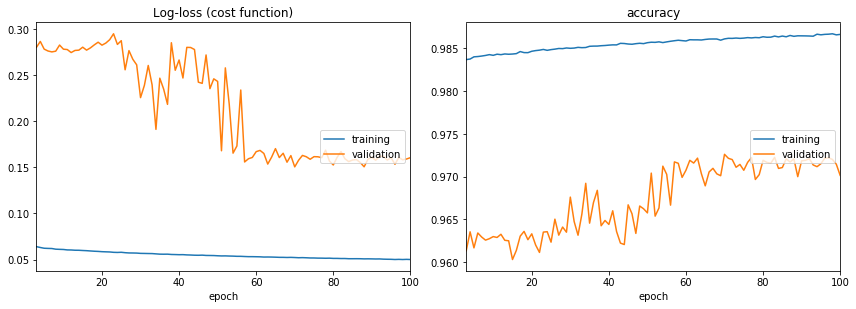

Log-loss (cost function):
training   (min:    0.050, max:    0.099, cur:    0.050)
validation (min:    0.150, max:    0.295, cur:    0.160)

accuracy:
training   (min:    0.978, max:    0.987, cur:    0.987)
validation (min:    0.960, max:    0.973, cur:    0.970)



In [79]:
filepath = "model{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint('models/%s'%filepath, 
                            monitor='val_acc',
                           verbose=0,
                           save_best_only=False)

history = model.fit(x_train, y_train,
                   validation_data=(x_valid, y_valid),
                   epochs=100,
                   callbacks=[PlotLossesCallback(),
                              TQDMNotebookCallback(leave_inner=False, leave_outer=True),
                             checkpoint],
                   verbose=0,
                   batch_size=1024)

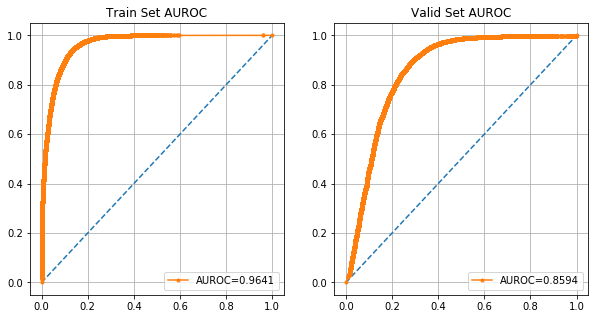

In [82]:
y_train_hat = model.predict(x_train)
y_valid_hat = model.predict(x_valid)

y_train_test = y_train[y_train.columns[0]]
y_train_hat_test = pd.DataFrame(y_train_hat)[pd.DataFrame(y_train_hat).columns[0]]
y_valid_test = y_valid[y_valid.columns[0]]
y_valid_hat_test = pd.DataFrame(y_valid_hat)[pd.DataFrame(y_valid_hat).columns[0]]

plt.figure(figsize=(10, 5))
show_auroc(y_train_test, y_train_hat_test, 1)
show_auroc(y_valid_test, y_valid_hat_test, 2)
plt.show()

models/model01.hdf5


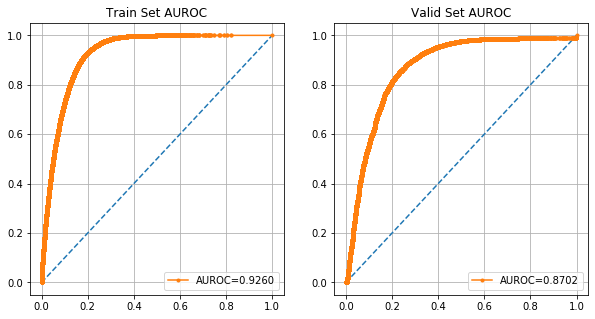

models/model02.hdf5


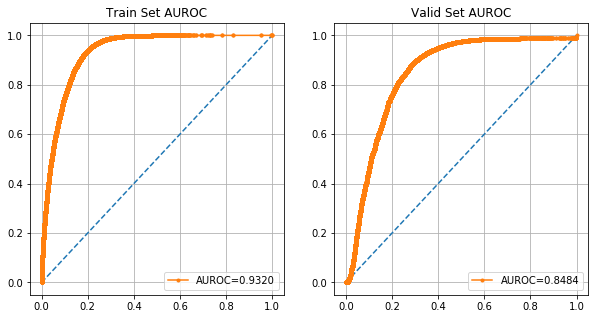

models/model03.hdf5


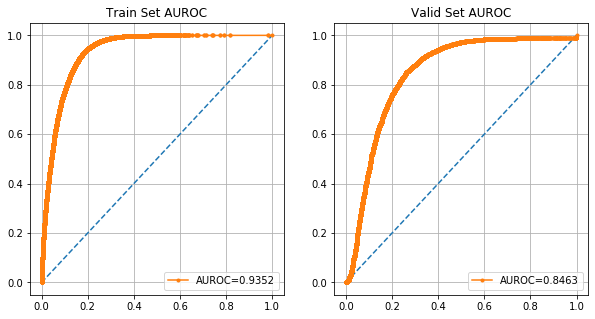

models/model04.hdf5


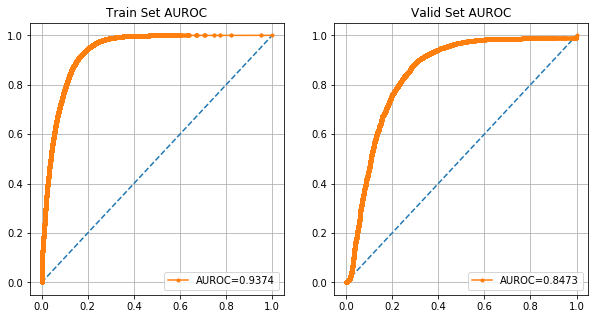

models/model05.hdf5


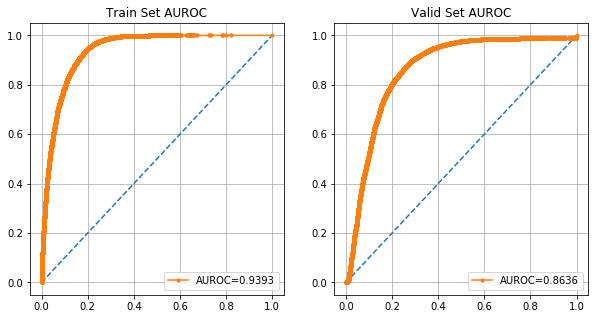

models/model06.hdf5


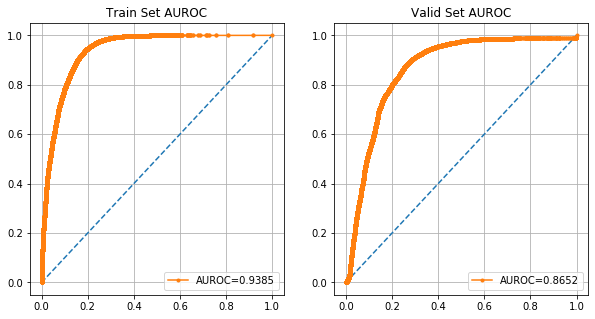

models/model07.hdf5


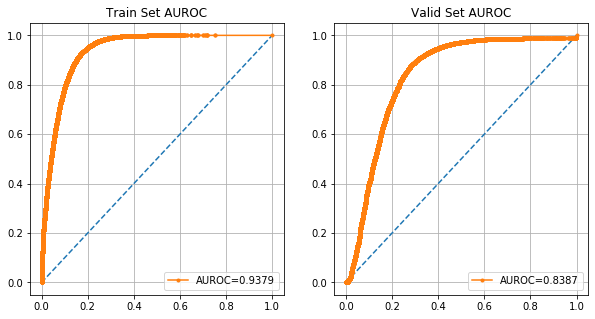

models/model08.hdf5


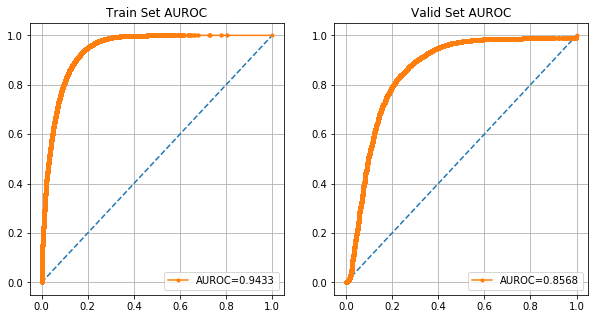

models/model09.hdf5


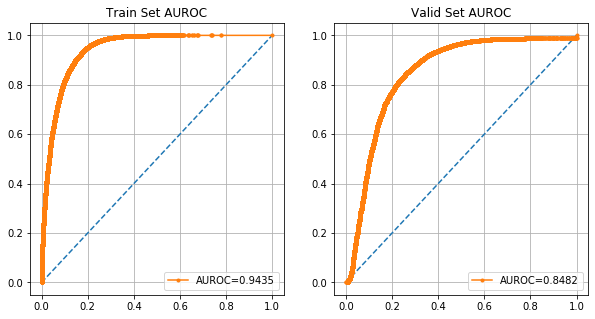

models/model10.hdf5


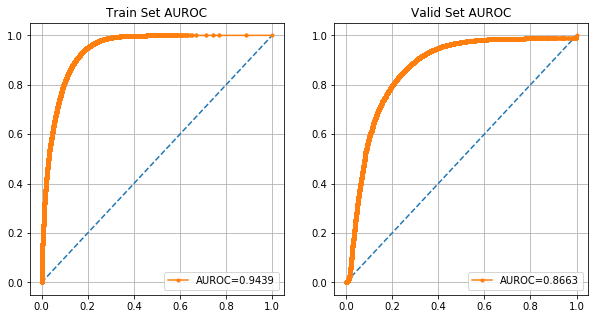

models/model100.hdf5


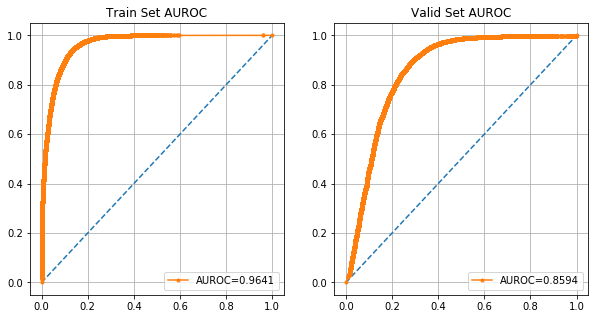

models/model11.hdf5


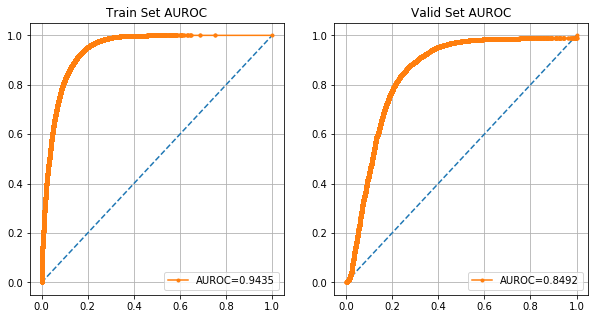

models/model12.hdf5


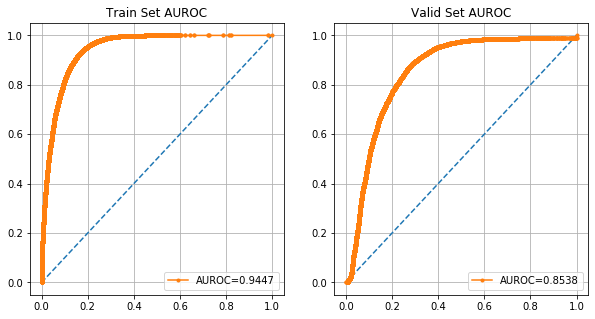

models/model13.hdf5


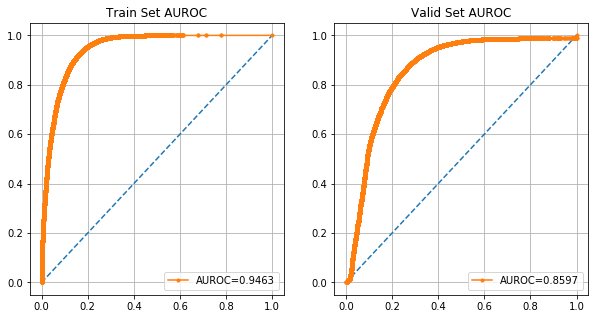

models/model14.hdf5


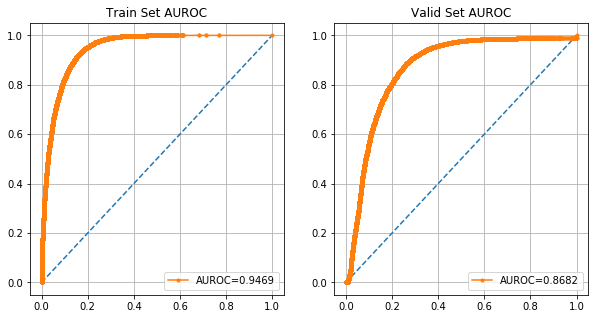

models/model15.hdf5


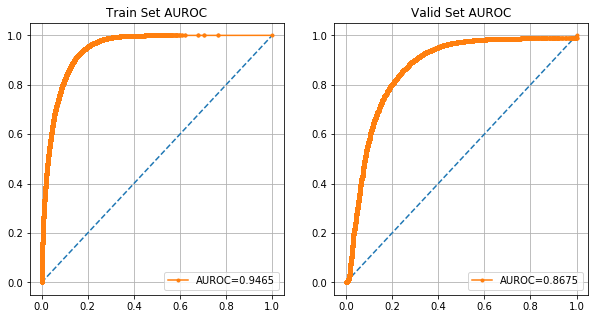

models/model16.hdf5


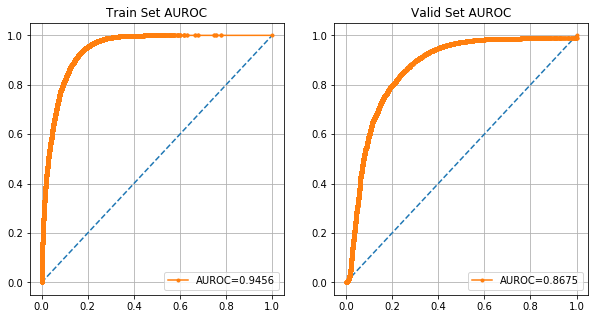

models/model17.hdf5


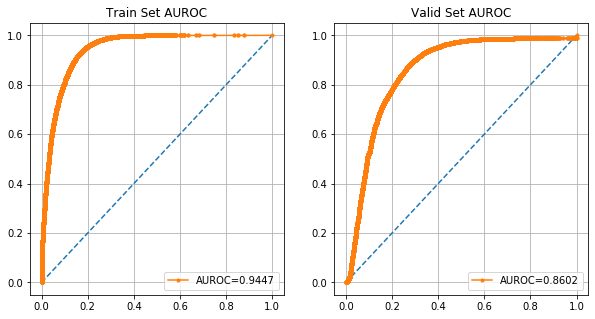

models/model18.hdf5


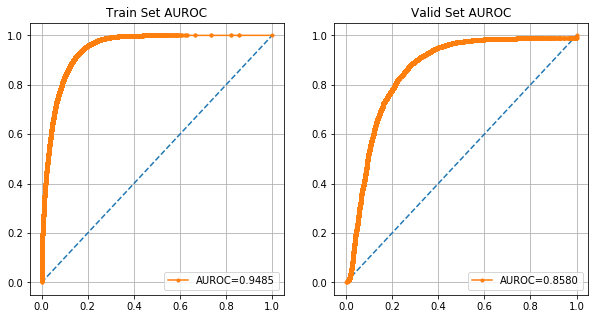

models/model19.hdf5


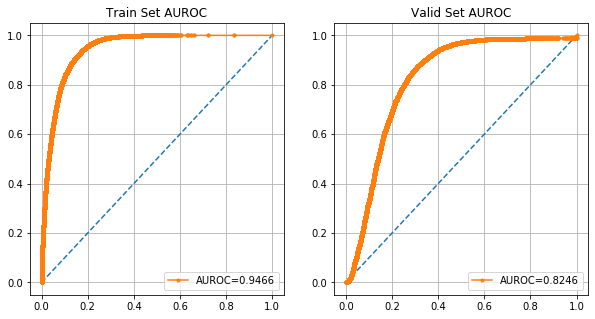

models/model20.hdf5


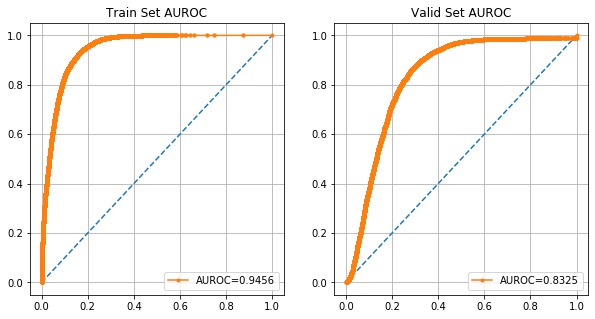

models/model21.hdf5


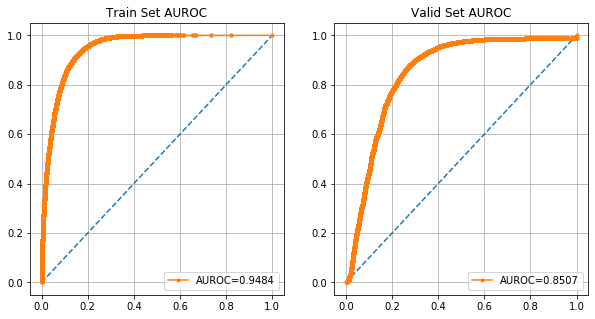

models/model22.hdf5


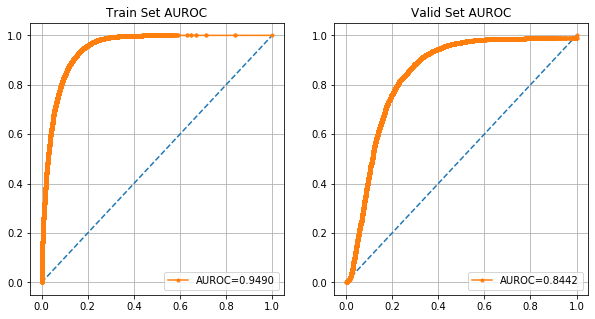

models/model23.hdf5


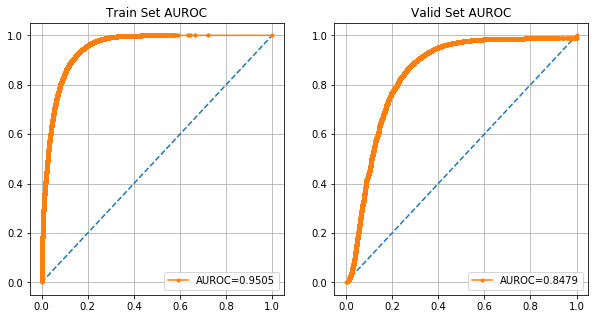

models/model24.hdf5


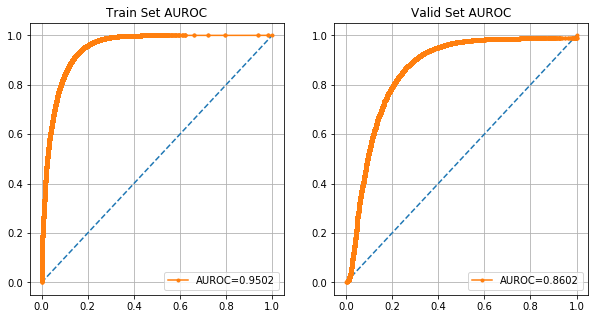

models/model25.hdf5


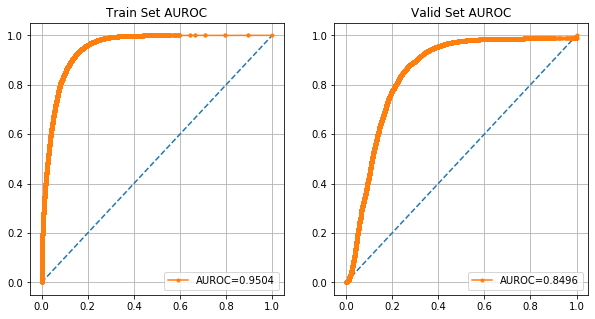

models/model26.hdf5


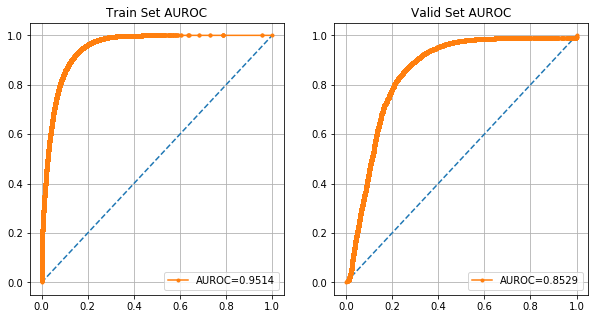

models/model27.hdf5


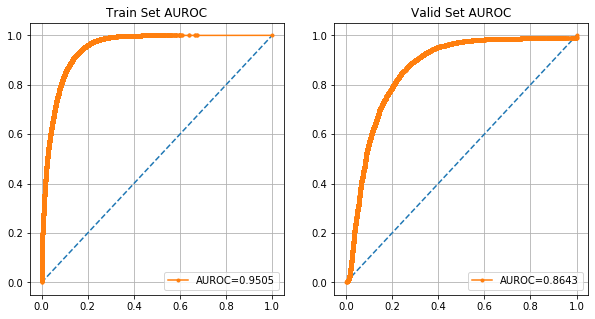

models/model28.hdf5


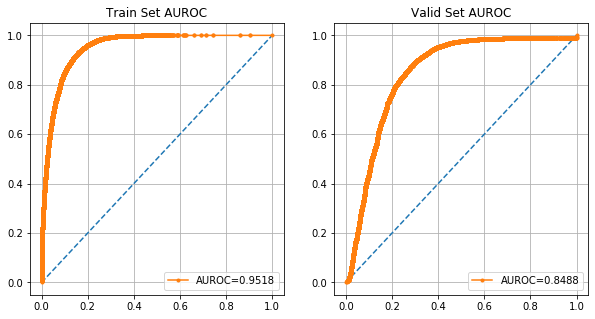

models/model29.hdf5


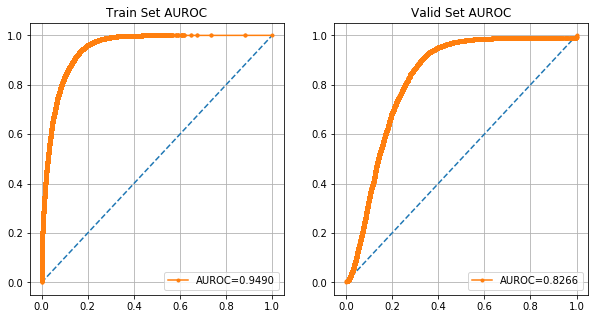

models/model30.hdf5


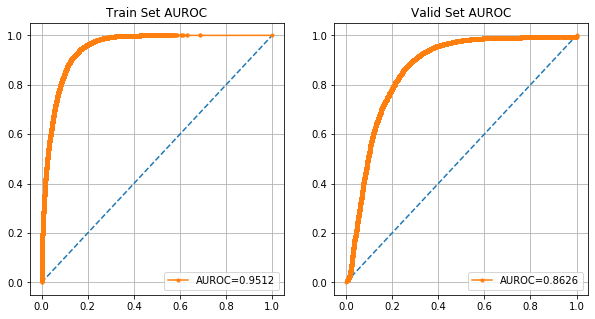

models/model31.hdf5


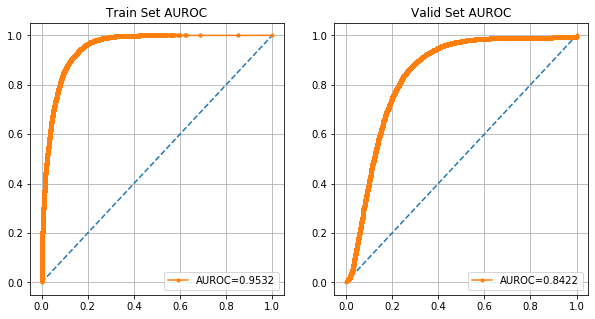

models/model32.hdf5


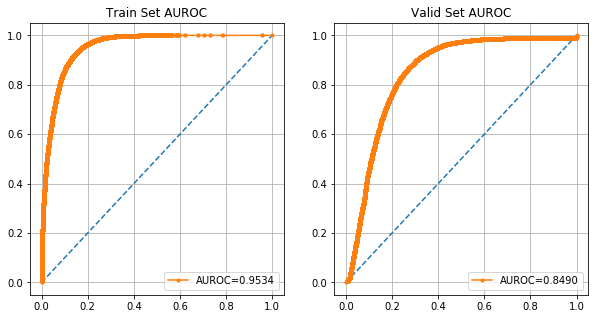

models/model33.hdf5


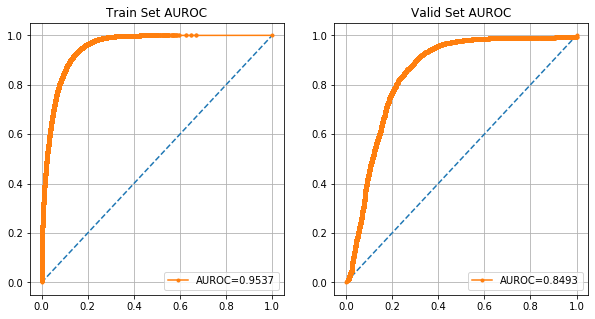

models/model34.hdf5


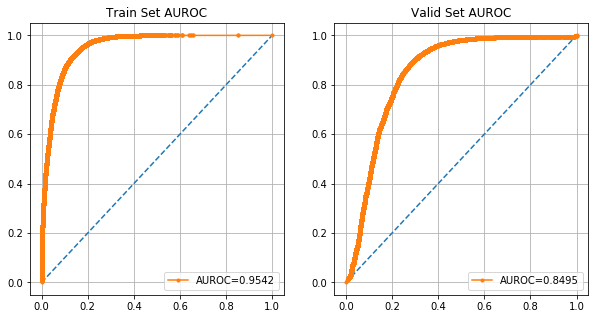

models/model35.hdf5


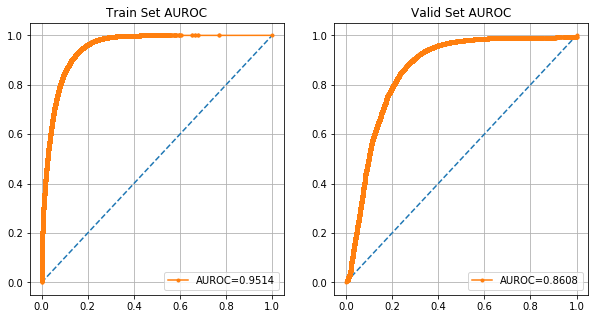

models/model36.hdf5


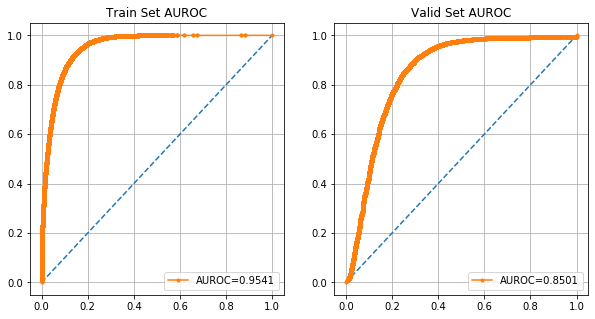

models/model37.hdf5


In [ ]:
filelist = os.listdir('models')
filelist.sort()

for filename in filelist :
    filepath = 'models/%s' %filename
    print(filepath)
    
    model.load_weights(filepath)
    
    y_train_hat = model.predict(x_train)
    y_valid_hat = model.predict(x_valid)

    y_train_test = y_train[y_train.columns[0]]
    y_train_hat_test = pd.DataFrame(y_train_hat)[pd.DataFrame(y_train_hat).columns[0]]
    y_valid_test = y_valid[y_valid.columns[0]]
    y_valid_hat_test = pd.DataFrame(y_valid_hat)[pd.DataFrame(y_valid_hat).columns[0]]

    plt.figure(figsize=(10, 5))
    show_auroc(y_train_test, y_train_hat_test, 1)
    show_auroc(y_valid_test, y_valid_hat_test, 2)
    plt.show()

models/model37.hdf5



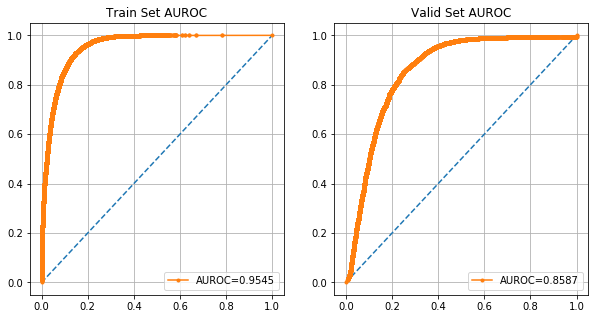

models/model38.hdf5


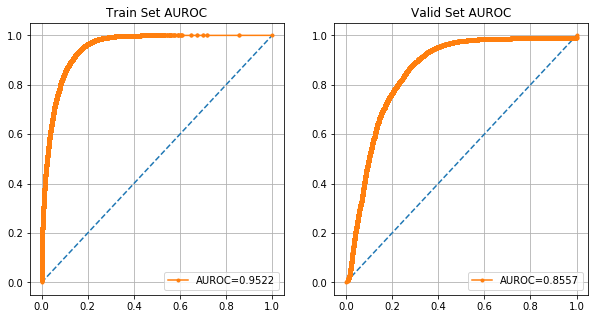

models/model39.hdf5


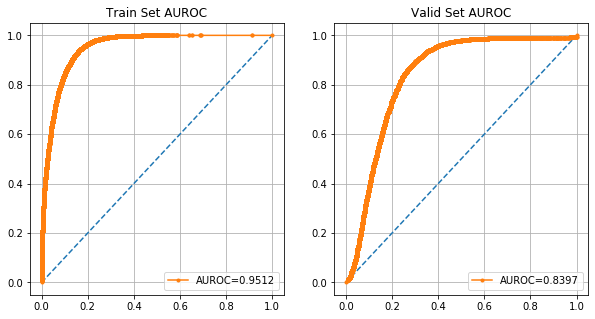

models/model40.hdf5


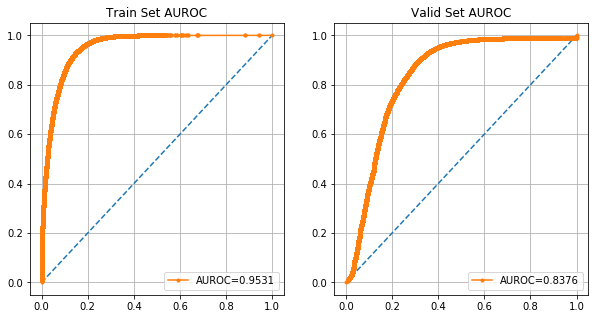

models/model41.hdf5


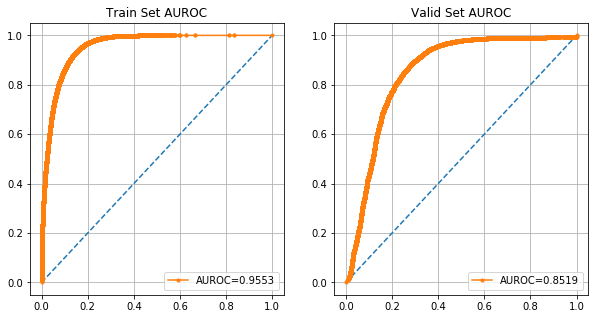

models/model42.hdf5


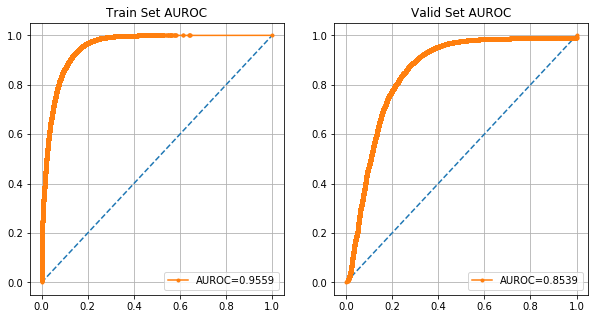

models/model43.hdf5


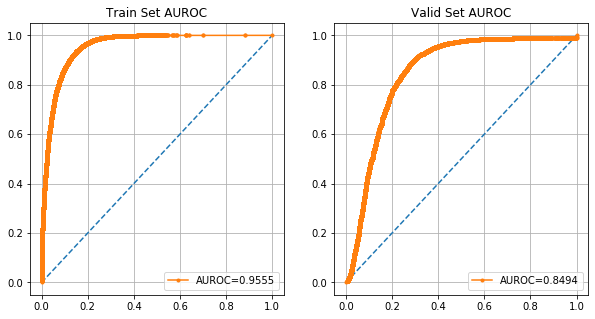

models/model44.hdf5


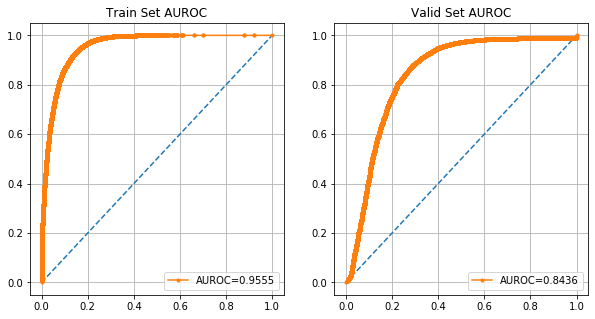

models/model45.hdf5


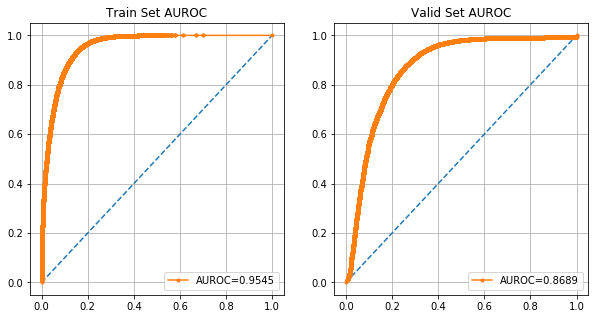

models/model46.hdf5


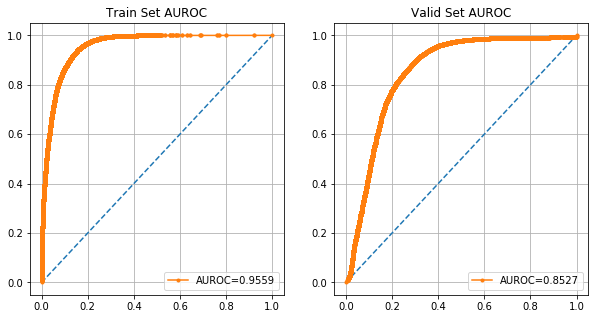

models/model47.hdf5


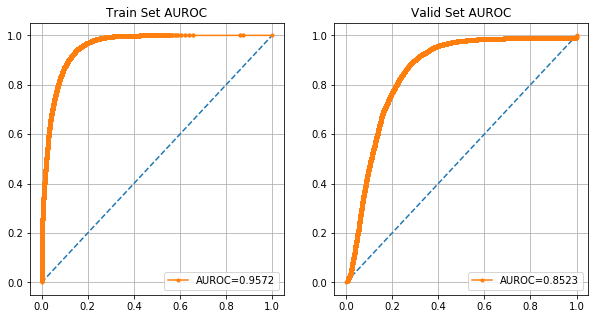

models/model48.hdf5


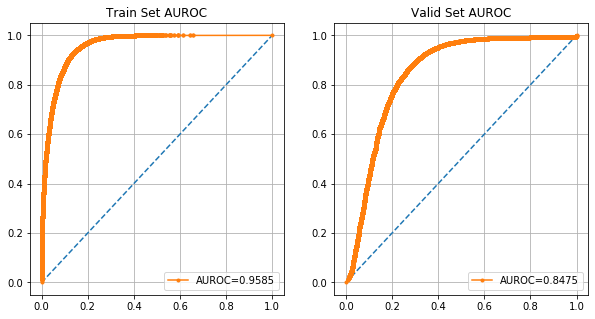

models/model49.hdf5


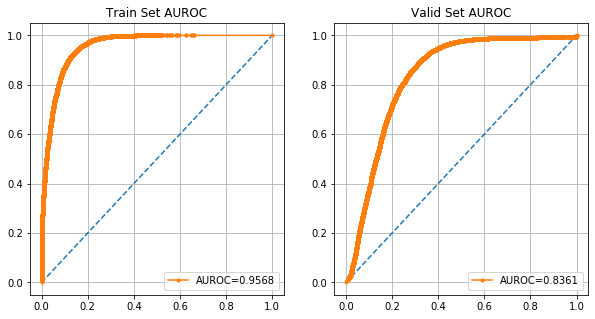

models/model50.hdf5


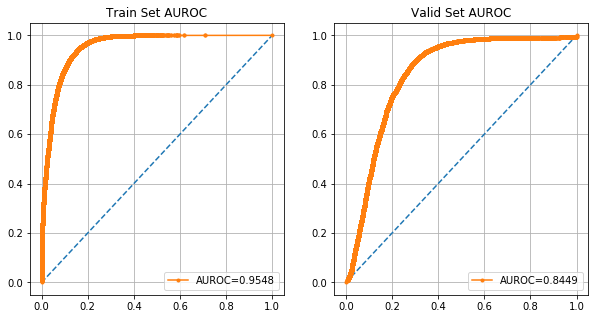

models/model51.hdf5


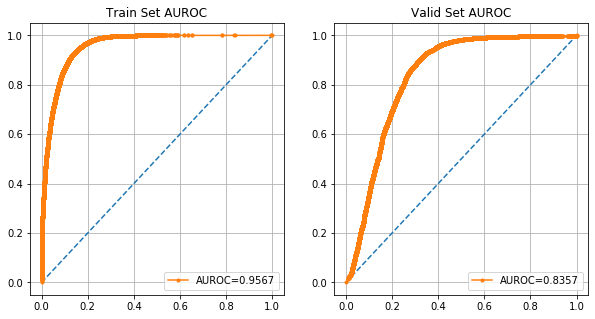

models/model52.hdf5


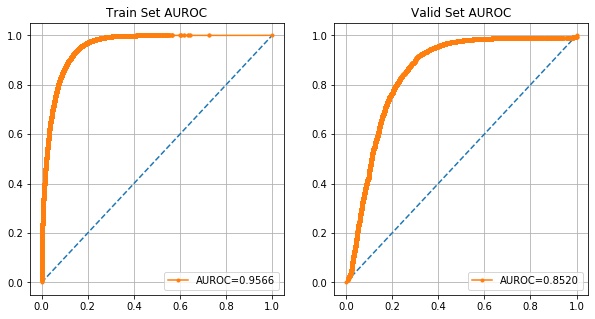

models/model53.hdf5


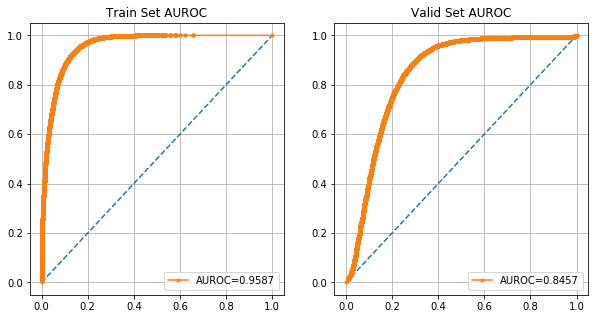

models/model54.hdf5


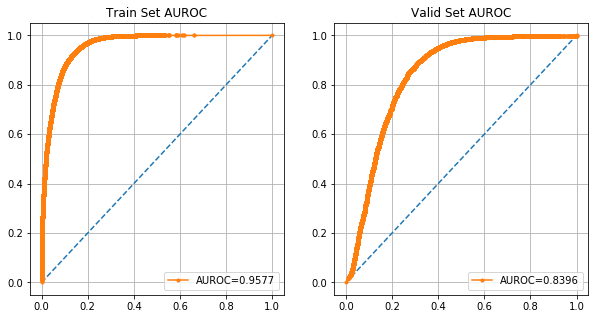

models/model55.hdf5


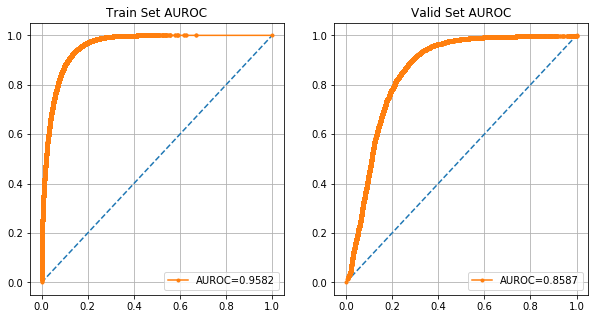

models/model56.hdf5


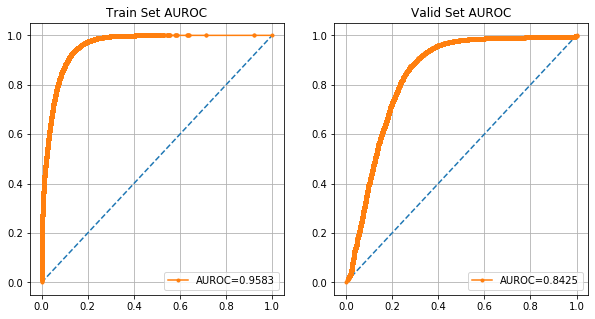

models/model57.hdf5


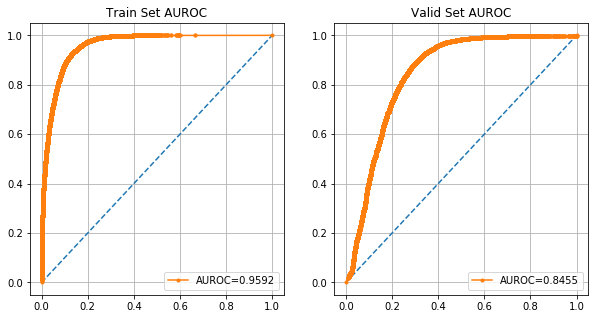

models/model58.hdf5


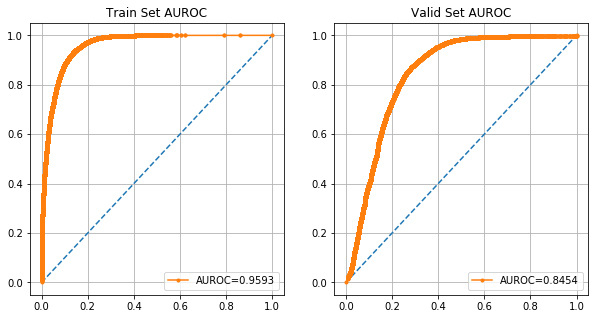

models/model59.hdf5


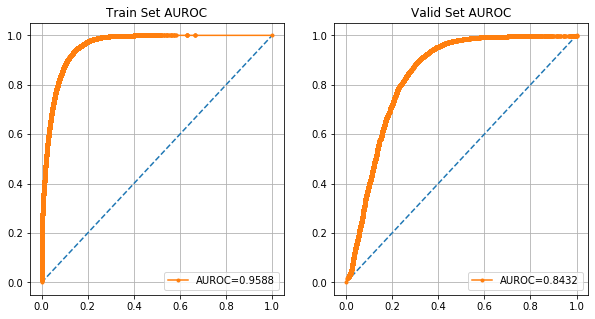

models/model60.hdf5


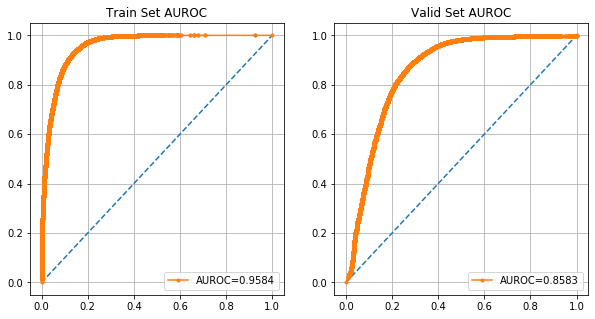

models/model61.hdf5


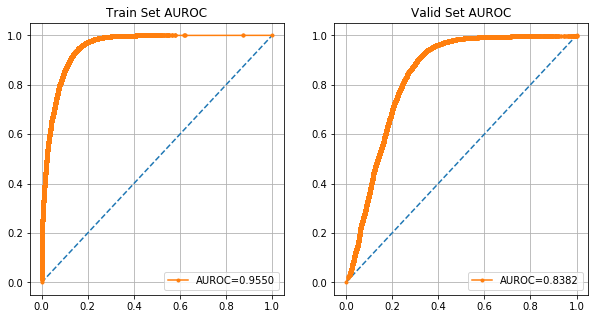

models/model62.hdf5


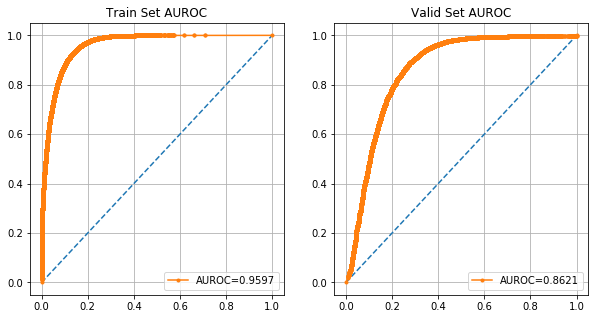

models/model63.hdf5


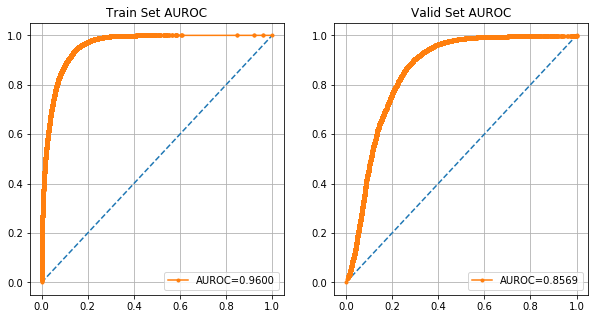

models/model64.hdf5


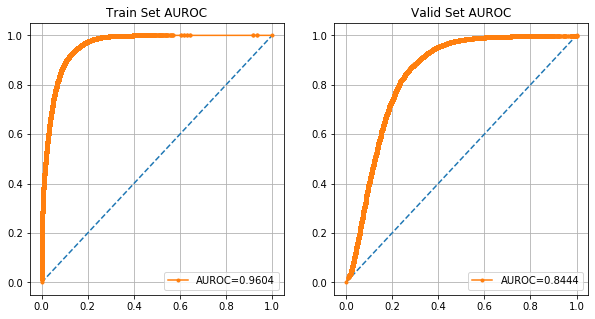

models/model65.hdf5


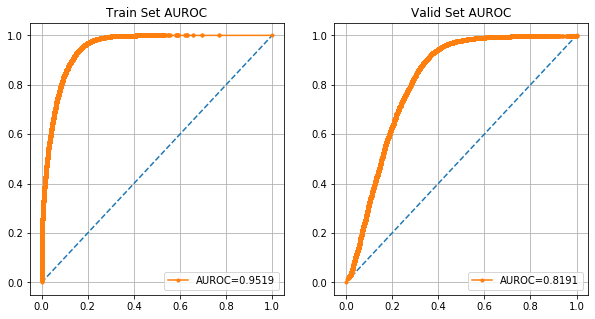

models/model66.hdf5


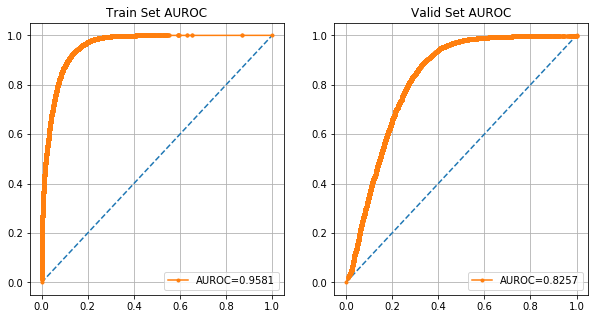

models/model67.hdf5


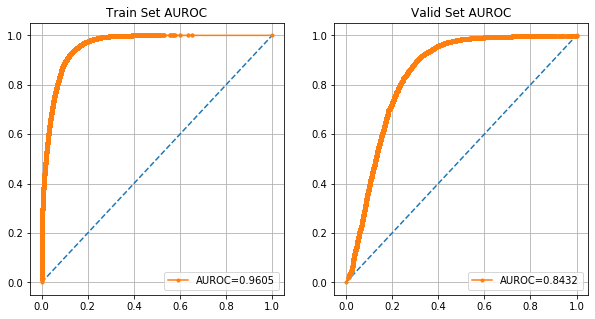

models/model68.hdf5


KeyboardInterrupt: 

In [19]:
filelist = os.listdir('models')
filelist.sort()

for filename in filelist[37:] :
    filepath = 'models/%s' %filename
    print(filepath)
    
    model.load_weights(filepath)
    
    y_train_hat = model.predict(x_train)
    y_valid_hat = model.predict(x_valid)

    y_train_test = y_train[y_train.columns[0]]
    y_train_hat_test = pd.DataFrame(y_train_hat)[pd.DataFrame(y_train_hat).columns[0]]
    y_valid_test = y_valid[y_valid.columns[0]]
    y_valid_hat_test = pd.DataFrame(y_valid_hat)[pd.DataFrame(y_valid_hat).columns[0]]

    plt.figure(figsize=(10, 5))
    show_auroc(y_train_test, y_train_hat_test, 1)
    show_auroc(y_valid_test, y_valid_hat_test, 2)
    plt.show()